# Profile designer
This is the playground to design functions to fit the vertical structure of the East Atlantic's atmosphere in boreal summer. The data comes from previously extracted ERA5 profiles (from `Create-era5.ipynb`), and should be available in a local directory `./data/`. Two hypercube centers (south and north sub-domain) are then defined based on a set of chosen functions and free parameters, and stored in `./runs/`. The parameters for these runs are stored in a .csv; the input profiles for DALES in its usual format.

Additionally, a vertical grid, nudging profile and a backrad profile are defined, which can be used for all simulations in the eventual ensemble.

In [1]:
import intake
import healpy as hp
import cmocean
import numpy as np
import xarray as xr
import pandas as pd
import os
from scipy.optimize import curve_fit

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

import easygems.healpix as egh
import seaborn as sns

import thermo
import netCDF4 as nc

from profiles import *
import utils

from functools import partial

In [2]:
Lv = 2.5e6
cp = 1004.
Rd = 287.05
grav = 9.81

data_path = './data'
data_path_fp = data_path+'/data_fp'

Text(0, 0.5, 'zf [m]')

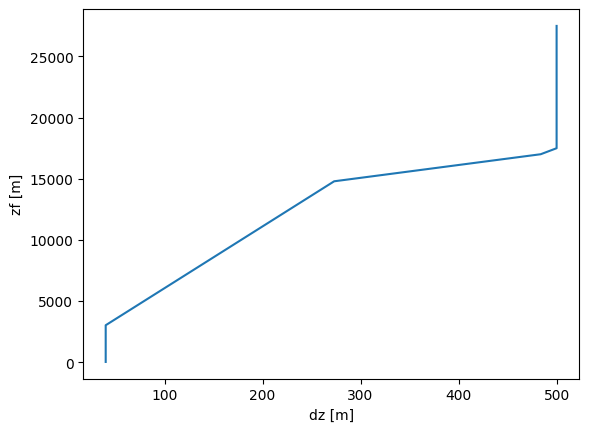

In [3]:
# Grid for DALES simulations, inspired by RCEMIP grid and EUREC4A grid

zlowmax = 3e3
dzlow   = 40
nztot   = 200
r0      = 1.02
zlow1max= 15e3 
r1      = 1.1
dzmax   = 500.

# Set the grid
zh, zf, = utils.make_grid(zlowmax, dzlow, nztot, r0, zlow1max, r1, dzmax=dzmax)

dz = np.diff(zh)
plt.plot(dz, zf)
plt.xlabel('dz [m]')
plt.ylabel('zf [m]')

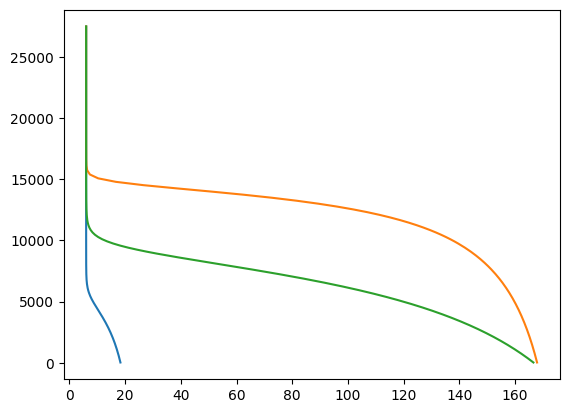

In [24]:
# Nudging functions used in https://doi. org/10.1029/2023MS003796
def _nudge_atan(x, a=5, b=2, c=20, lev_max_change=5000, end=3600*6, test_plot=False):
            y = b * (np.pi/2+np.arctan(a* np.pi/2*(1-x/lev_max_change)))
            y = end + y**c
            # plot
            if test_plot:
                plt.figure(figsize=(6,9))
                plt.plot(y,x)
                plt.xlim([10e3,10e8])
                plt.ylim([0,5000])
                plt.xscale('log')
            return y

def create_nudging(zf, thl, qt, u, v, nudge_params):
    """
    Makes a nudging input file, based on 
    profiles to nudge towards of
    - zf
    - thl
    - qt
    - u
    - v
    nudge_params is a tuple that contains the input parameters to Alessandro's 
    arctangent nudging function.
    """
    
    zero = np.zeros(zf.shape)
    (a,b,c,z_max_change,tnudge_ft) = nudge_params
    
    # Nudging factor with height; 
    # is multiplied with nudging time (tnudgefac) from namelist;
    # here we set tnudgefac=1 -> Then this is the nudging time in seconds
    nudgefac = _nudge_atan(zf,a,b,c,z_max_change,tnudge_ft)
    
    out_profs = np.stack((zf,nudgefac,u,v,zero,thl,qt)).T
    
    return out_profs

## INITIAL ATTEMPT - NUDGING TOO STRONG
tnudge_ft = 6 # hours
lev_max_change = 6000 # m
nudge_params_0 = (2,3,5,lev_max_change,tnudge_ft*3600) # ~18 hours near the surface
t_nudge_0 = _nudge_atan(zf,nudge_params_0[0],nudge_params_0[1],nudge_params_0[2],nudge_params_0[3],nudge_params_0[4])

## SECOND ATTEMPT - WEAKER NUDGING
tnudge_ft = 6 # hours
lev_max_change = 15000 # m
nudge_params_1 = (10,4.622,5,lev_max_change,tnudge_ft*3600) # ~7 days over FT
t_nudge_1 = _nudge_atan(zf,nudge_params_1[0],nudge_params_1[1],nudge_params_1[2],nudge_params_1[3],nudge_params_1[4])

## THIRD ATTEMPT - STRONGER NUDGING OF THL IN UPPER FT TO PREVENT RUNAWAY COOLING
tnudge_ft = 6 # hours
lev_max_change_2 = 10000 # m
nudge_params_2 = (3,4.622,5.09,lev_max_change_2,tnudge_ft*3600) # ~18 hours near the surface
t_nudge_2 = _nudge_atan(zf,nudge_params_2[0],nudge_params_2[1],nudge_params_2[2],nudge_params_2[3],nudge_params_2[4])

plt.figure()
plt.plot(t_nudge_0/3600,zf)
plt.plot(t_nudge_1/3600,zf)
plt.plot(t_nudge_2/3600,zf)

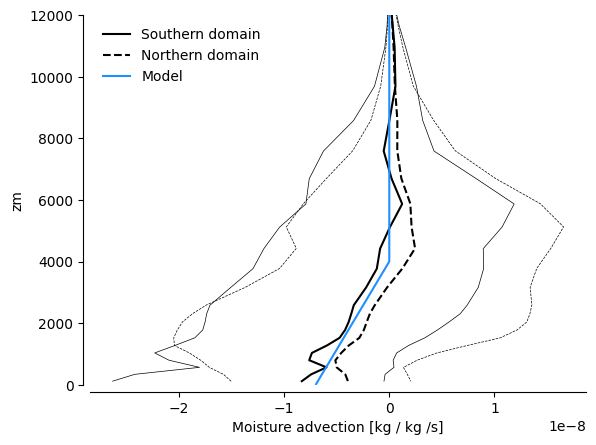

In [25]:
## Horizontal advection, from a lat/lon grid

from utils import interpolate_to_latlon

era5_env_s = xr.open_dataset(data_path+'/era5_env_s.nc')
era5_env_n = xr.open_dataset(data_path+'/era5_env_n.nc')

era5_env_s_ll = interpolate_to_latlon(era5_env_s)
era5_env_n_ll = interpolate_to_latlon(era5_env_n)

# Model
qadv0 = 7e-9
dqadvdz = qadv0/4000
qadv_mod = -qadv0 + dqadvdz*zf
qadv_mod = np.clip(qadv_mod, a_min=None, a_max=0)

# South
era5_env_s_ll['q_adv_h'] = (-era5_env_s_ll['u'] * era5_env_s_ll['q'].differentiate('lon')
                            -era5_env_s_ll['v'] * era5_env_s_ll['q'].differentiate('lat')) / 1e5 # lat/lon => m

# Horizontal advection envelope
era5_env_s_ll['q_adv_h'].median(['time','lon','lat']).plot(y='zm', c='k', label='Southern domain')
era5_env_s_ll['q_adv_h'].quantile(0.25, dim=['time','lon','lat']).plot(y='zm', c='k', lw=0.5)
era5_env_s_ll['q_adv_h'].quantile(0.75, dim=['time','lon','lat']).plot(y='zm', c='k', lw=0.5)

# North
era5_env_n_ll['q_adv_h'] = (-era5_env_n_ll['u'] * era5_env_n_ll['q'].differentiate('lon')
                            -era5_env_n_ll['v'] * era5_env_n_ll['q'].differentiate('lat')) / 1e5 # lat/lon => m

era5_env_n_ll['q_adv_h'].median(['time','lon','lat']).plot(y='zm', c='k', linestyle='--', label='Northern domain')
era5_env_n_ll['q_adv_h'].quantile(0.25, dim=['time','lon','lat']).plot(y='zm', c='k', linestyle='--', lw=0.5)
era5_env_n_ll['q_adv_h'].quantile(0.75, dim=['time','lon','lat']).plot(y='zm', c='k', linestyle='--', lw=0.5)

# Model
plt.plot(qadv_mod, zf, color='dodgerblue', label='Model')

plt.ylim(0,12e3)
plt.legend(frameon=False)
plt.title('')
plt.xlabel('Moisture advection [kg / kg /s]')

sns.despine(offset=5)

Free parameter values:
         thls  dthllt  rhft        u0      ujet
0  299.959967      -1   0.6  3.414611  2.896884
ps (rounded for all simulations): 101300
Actual thls - thl[0]: 1.25
Free parameter values:
       thls  dthllt  rhft        u0     ujet
0  299.5069     2.5  0.45  1.796379  6.52969
ps (rounded for all simulations): 101300
Actual thls - thl[0]: 1.25


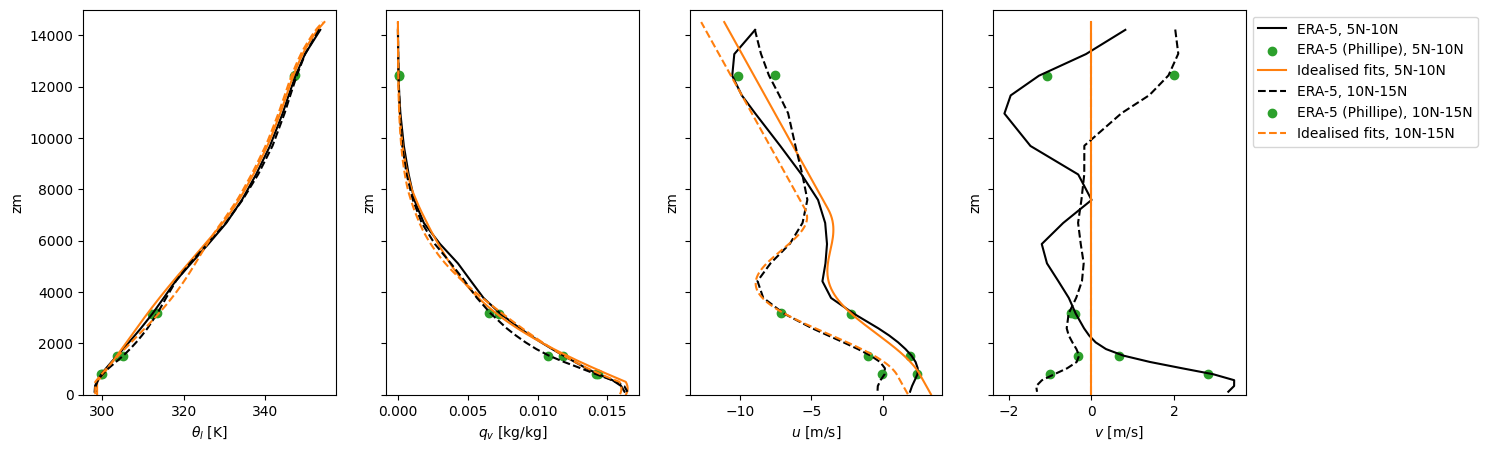

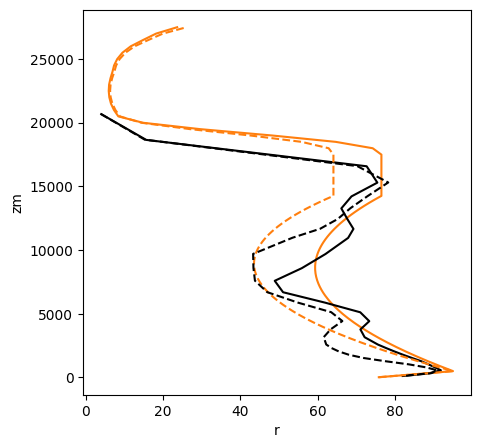

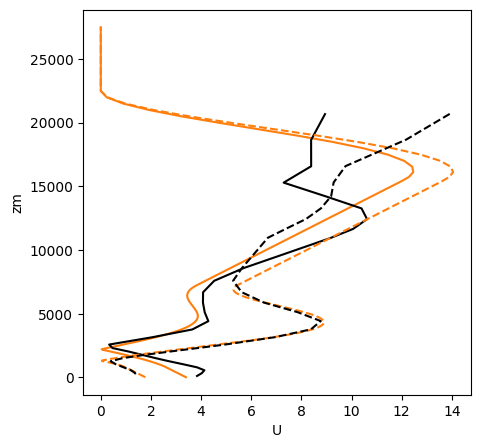

In [23]:
## Mean profiles
# era5 profiles, averaged over ~1200 summer days (Jul-Sep 2010-2023) and
# southern subdomain -  5N-10N, 23W-29W
# northern subdomain - 10N-15N, 23W-29W

# Surface pressure to use for all runs
ps_fixed = 101300 # Pa

# fitting height range
zfitmin = 0
zfitminu = 2e3
zfitmax = 8e3
# zfitmax = 15e3 # Raised for ensemble-4

# plotting range
zpltmax = 15e3

# domain names
doms = ['s', 'n']
lats = ['5N-10N','10N-15N']

# Plot settings
cs = ['black', 'C1', 'C2', 'C3']
lss = ['-','--']

# Where to store output files
out_dir = './runs/run_'

# relaxation to reference state using ERA5, which is
# - the southern domain mean stratosphere for q/theta_l (at different heights!)
# - zero for u and v
href_relax_thl=19e3 # Relax to same profile in the upper troposphere, which we do not control
hsca_relax_thl=3e3
z0_extend_thl=7e3
href_relax_qt=19e3
hsca_relax_qt=3e3
href_relax_u=19e3 # Above the tropopause, relax to zero
hsca_relax_u=7e3

fig, axs = plt.subplots(ncols=4,figsize=(15,5),sharey=True)

fig_rh, ax_rh = plt.subplots(ncols=1,figsize=(5,5))

fig_u, ax_u = plt.subplots(ncols=1,figsize=(5,5))


dthllta = [-1,2.5]
rhft = [0.6,0.45]

# for i in range(1):
for i in range(len(doms)):
    # ERA5 from DKRZ (Create-era5.ipynb)
    era5_env_mn = xr.open_dataset(data_path+'/era5_env_'+doms[i]+'_mn.nc')

    # Manually retrieved ERA5 from Copernicus (used for higher levels, which do not exist in HERA5 from DKRZ)
    era5_allplev = xr.open_dataset(data_path+'/era5_month_allplev_'+doms[i]+'.nc').sel(expver=1)
    era5_allplev['zm'] = (era5_allplev['z']/grav).mean(['time','latitude','longitude'])
    era5_allplev = era5_allplev.set_coords(['zm']).swap_dims({'level':'zm'})
    era5_allplev['pres'] = era5_allplev['level'] * 100
    era5_allplev['theta_l']  = (1e5/era5_allplev['pres'])**(2/7)*(era5_allplev['t']) # FIXME Ignores clouds
        
    era5_allplev_mn = era5_allplev.mean(['time','latitude','longitude'])

    if i == 0:
        if doms[i] != 's':
            print('WARNING: Will not take the southern domain as reference, and will fail')
        era5_ref = era5_allplev_mn.copy(deep=True)
    
    # Surface pressure and surface theta_l
    thls = era5_env_mn['sst']*(1e5/ps_fixed)**(2./7)

    # Use HERA5 (from DKRZ) for fits in lower troposphere
    era5_env_mn_fit = era5_env_mn.sel(zm=slice(zfitmax,zfitmin)).astype('float64')
    zfit = era5_env_mn['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')

    # Use a different range for u, to avoid fitting near-surface mixing which we want to model
    era5_env_mn_fit_u = era5_env_mn.sel(zm=slice(zfitmax,zfitminu)).astype('float64')
    zfit_u = era5_env_mn['zm'].sel(zm=slice(zfitmax,zfitminu)).astype('float64')

    # fit profiles
    # OLD fitting the lower troposphere accurately
    # [thlsf,dthllt], pcth = curve_fit(linml_sl,
    #                                 zfit, 
    #                                 era5_env_mn_fit['theta_l'], 
    #                                 p0=[300,0.1])
    
    # now controlling the stability over a deeper layer instead
    dthllt = dthllta[i]
    
    # OLD with varying qt0, which hardly varies
    # [qt0,hqt], pcqt = curve_fit(exp,
    #                             zfit,
    #                             era5_env_mn_fit['q'],
    #                             p0=[0.016,1500])

    # OLD direct fitting of qt
    # [hqt], pcqt = curve_fit(exp_h_lt,
    #                         zfit,
    #                         era5_env_mn_fit['q'],
    #                         p0=[1500])

    # mid-tropospheric rh control
    rhfti = rhft[i]

    # OLD with varying shear, which gives better fits, but adds a difference between centers
    # [u0,dudz,ujet], pcu = curve_fit(linv_aej,
    #                                 zfit_u,
    #                                 era5_env_mn_fit_u['u'],
    #                                 p0=[-1, 0.00222,6])
    
    # With fixed shear, only jet
    [u0,ujet], pcu = curve_fit(linv_aej_fs,
                                zfit_u,
                                era5_env_mn_fit_u['u'],
                                p0=[-1, 6])

    ## OLD center included v
    [v0,dvdz], pcv = curve_fit(linv,
                               zfit_u,
                               era5_env_mn_fit_u['v'],
                               p0=[0,0])

    print('Free parameter values:')
    df_par = pd.DataFrame(data={'thls':thls.mean().data,
                                'dthllt':dthllt,
                                # 'hqt':hqt,
                                'rhft':rhfti,
                                'u0':u0,
                                'ujet':ujet,
                                },
                         index=[0])
    print(df_par)
    out_dir_i = out_dir+str(i+1)
    df_par.to_csv(os.path.join(out_dir_i, 'parameters.csv'), index=False)
    
    # print('Parameters fixed for cube, but different between centers:')
    # print('Mean ps:', era5_env_mn['sp'].mean().data)
    print('ps (rounded for all simulations):', ps_fixed)

    # evaluate profiles
    thl = linml_sl(zf, thls.mean().data, dthllt)
    thl = extend_thl(zf, thl, era5_ref['theta_l'], z0_extend_thl)
    thl = relax(zf, thl, era5_ref['theta_l'], href_relax_thl, hsca_relax_thl)

    # Direct qt control
    # qt = exp_h_lt(zf, hqt)

    # Direct rh control
    rh = rh_c(zf, rhfti)
    qt = qt_from_rh(zf, rh, thl)
    qt = relax(zf, qt, era5_ref['q'], href_relax_qt, hsca_relax_qt)
    
    u = linv_aej_fs(zf, u0, ujet)
    u = relax(zf, u, era5_ref['u']*0, href_relax_u, hsca_relax_u)
    
    # Set v to zero
    v = linv(zf, v0, dvdz)
    v = v*0.
    v = relax(zf, v, era5_ref['v']*0, href_relax_u, hsca_relax_u)
        
    # check that thls>thl[0]
    dthls0 = thls.mean().data-thl[0]
    print('Actual thls - thl[0]:', dthls0)

    ## Compare with the mean profiles from Phillipe

    ds_t_pp = xr.open_dataset(data_path_fp+'/t_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')
    ds_q_pp = xr.open_dataset(data_path_fp+'/q_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')
    ds_u_pp = xr.open_dataset(data_path_fp+'/u_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')
    ds_v_pp = xr.open_dataset(data_path_fp+'/v_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')
    ds_d_pp = xr.open_dataset(data_path_fp+'/d_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')

    ds_pp = xr.merge([ds_t_pp, ds_q_pp, ds_u_pp, ds_v_pp, ds_d_pp])

    ## Move these data to the heights of the finer dataset, and convert t to potential t
    ds_pp['theta_l'] = ds_pp['t']*(1e5/ds_pp['lev']/100)**(2./7)
    ds_pp['z'] = era5_env_mn['theta_l'].swap_dims({'zm':'level'}).sel(level=ds_pp['lev'])
    ds_pp = ds_pp.swap_dims({'lev':'z'})
    
    ## Check RH
    # Interpolate pressure to model grid for RH calculations
    # pres = (era5_allplev_mn['level']*100)
    # pres0 = era5_env_mn['sp']
    # pres_np = np.flip(np.append(pres.to_numpy(),pres0.to_numpy()))
    # zm_np = np.flip(np.append(pres['zm'].to_numpy(), 0.))
    # pres = xr.DataArray(data=pres_np, coords={'zm':zm_np})
    # pres_zf = pres.interp(zm=zf,kwargs={"fill_value": "extrapolate"})
    rh = rhProf(zf, thl, qt, ps_fixed)

    ## Check momentum
    # mean-flow total momentum (not equal mean of total momentum)
    U = np.sqrt(u**2 + v**2)
    era5_env_mn['U'] = np.sqrt(era5_env_mn['u']**2 + era5_env_mn['v']**2)
    
    ## Plot everything up to zpltmax (so this plot may truncate the simulation grid if zpltmax < zf[-1])
    izmax = np.where(zf<zpltmax)[0][-1]
    zfplt = zf[:izmax]
    era5_env_mn_plt = era5_env_mn.sel(zm=slice(np.max(zfplt),np.min(zfplt)))

    era5_env_mn_plt['theta_l'].plot(y='zm', ax=axs[0], color=cs[0], linestyle=lss[i])
    axs[0].scatter(ds_pp['theta_l'], ds_pp['zm'], c=cs[2])
    axs[0].plot(thl[:izmax], zfplt, color=cs[1], linestyle=lss[i])
    axs[0].set_xlabel(r'$\theta_l$ [K]')

    era5_env_mn_plt['q'].plot(y='zm', ax=axs[1], color=cs[0], linestyle=lss[i])
    axs[1].scatter(ds_pp['q'], ds_pp['zm'], c=cs[2])
    axs[1].plot(qt[:izmax], zfplt, color=cs[1], linestyle=lss[i])
    axs[1].set_xlabel(r'$q_v$ [kg/kg]')

    era5_env_mn_plt['u'].plot(y='zm', ax=axs[2], color=cs[0], linestyle=lss[i])
    axs[2].scatter(ds_pp['u'], ds_pp['zm'], c=cs[2])
    axs[2].plot(u[:izmax], zfplt, color=cs[1], linestyle=lss[i])
    axs[2].set_xlabel(r'$u$ [m/s]')

    era5_env_mn_plt['v'].plot(y='zm', ax=axs[3], color=cs[0], linestyle=lss[i], label='ERA-5, '+lats[i])
    axs[3].scatter(ds_pp['v'], ds_pp['zm'], c=cs[2], label='ERA-5 (Phillipe), '+lats[i])
    axs[3].plot(v[:izmax], zfplt, color=cs[1], linestyle=lss[i], label='Idealised fits, '+lats[i])
    axs[3].set_xlabel(r'$v$ [m/s]')

    axs[3].legend(bbox_to_anchor=(1,1), loc='best')
    
    # Plot RH
    ax_rh.plot(rh, zf, linestyle=lss[i], color=cs[1])
    era5_env_mn['r'].plot(y='zm', ax=ax_rh, linestyle=lss[i], color=cs[0])

    # Plot U
    ax_u.plot(U, zf, linestyle=lss[i], color=cs[1])
    era5_env_mn['U'].plot(y='zm', ax=ax_u, linestyle=lss[i], color=cs[0])
    
    ## Write to DALES input format
    experiment='001'
    
    # prof.inp
    tke = 1 - zf/3000; tke[zf>=3000] = 0.
    prof = np.stack((zf,thl,qt,u,v,tke)).T
    profile_out = os.path.join(out_dir_i, 'prof.inp.'+experiment)
    np.savetxt(profile_out, prof, fmt='%12.6g',
               header='\n    height         thl          qt            u            v          TKE')

    # lscale.inp
    # no large-scale forcing other than nudging
    zero = np.zeros(zf.shape)

    lscale = np.stack((zf,u,v,zero,zero,zero,qadv_mod,zero)).T
    lscale_out = os.path.join(out_dir_i, 'lscale.inp.'+experiment)
    np.savetxt(lscale_out, lscale, fmt='%12.6g',
               header='\n    height           ug           vg         wfls      dqtdxls      dqtdyls      dqtdtls      dthlrad')

    # scalar.inp
    scalar = np.stack((zf,zero,zero)).T
    scalar_out = os.path.join(out_dir_i, 'scalar.inp.'+experiment)
    np.savetxt(scalar_out, scalar, fmt='%12.6g',
               header='#\nheight  nr  qr', comments='')
    
    # nudge.inp
    nudge_profs = create_nudging(zf, thl, qt, u, v, nudge_params_1)

    # Add separate thl nudging as the final column
    nudge_profs = np.hstack((nudge_profs,t_nudge_2.reshape(t_nudge_2.size,1)))
    
    nudge_out = os.path.join(out_dir_i, 'nudge.inp.'+experiment)
    f = open(nudge_out, 'w')
    f.close()
    
    # Append two time instances - one at start, one after end of simulation
    with open(nudge_out, 'ab') as f:
        np.savetxt(f, nudge_profs, fmt='%+10.10e', comments='',
                   header='\n      z (m)          factor (-)         u (m s-1)         v (m s-1)         w (m s-1)          thl (K)        qt (kg kg-1)        factor thl (-)    \n# 0.00000000E+00')
        np.savetxt(f, nudge_profs, fmt='%+10.10e', comments='',
                   header='\n      z (m)          factor (-)         u (m s-1)         v (m s-1)         w (m s-1)          thl (K)        qt (kg kg-1)        factor thl (-)    \n# 1.00000000E+07')

axs[0].set_ylim(0,zpltmax)
# axs[0].set_xlim(297,315)
plt.savefig(data_path+'/figures/prof-test.pdf',bbox_inches='tight')

In [ ]:
## Test the new stable layer aloft

In [ ]:
# backrad.inp.001.nc
# Since upper troposphere in all simulations is from the same ERA5 profile, we can use the same profile to extrapolate
# immediately above the TOM, without creating large spurious gradients, in all Botany simulations.

# Use from RCEMIP:
# - that the TOA is at 50 Pa
# - the function for o3(pres)
# - the humidity

# Where to store output files
out_dir_rad = './runs'

backrad_rce = xr.open_dataset(data_path+'/backrad_rce.nc')
brl = era5_ref.isel(zm=slice(None, None, -1)).swap_dims({'zm':'level'})
brl['level'] = brl['level']*100

## pressure (from ERA5, extrapolated to 50 Pa)
pres_br = np.hstack([brl['level'].to_numpy(), [50.]])

## temperature
# Extrapolate above ERA5 to 50 Pa level using the international standard atmosphere (https://www.digitaldutch.com/atmoscalc/)
# offset to fit at the highest ERA5 level
Tf = brl['t'].isel(level=-1)
dT_ISA = Tf - 270.650 # ISA offset
T50 = 256.488 # Offset ISA T at 50 Pa

T_br = np.hstack([brl['t'].to_numpy(), [T50]])

## q
# Extrapolate by assuming it stays constant at the final ERA5 value
q_br = np.hstack([brl['q'], [brl['q'][-1]]])

## o3
# Reconstruct RCEMIP profile (from Wing et al., 2018 - https://doi.org/10.5194/gmd-11-793-2018)
def o3_wing(p, g1, g2, g3):
    p = p/100 # Pa -> hPa
    return g1*p**g2*np.exp(-p/g3)/1e6

g1 = 3.6478
g2 = 0.83209
g3 = 11.3513
o3_rcemip = o3_wing(backrad_rce['lev'], g1, g2, g3)

# Use the same function to fit our o3 to TOA
[g1b, g2b, g3b], pco3 = curve_fit(o3_wing, brl['level'], brl['o3'], p0=[g1*1.6,g2,g3])
o3_br = o3_wing(pres_br, g1b, g2b, g3b)

# Create backrad
backrad_out = os.path.join(out_dir_rad,'backrad.inp.'+experiment+'.nc')

nc_file = nc.Dataset(backrad_out, 'w')
nc_file.title = 'Background radiation input for deep-botany simulations, from ERA5'

dims = nc_file.createDimension('lev', pres_br.size)

p_var = nc_file.createVariable('lev', 'f4', ('lev'))
T_var = nc_file.createVariable('T',   'f4', ('lev'))
q_var = nc_file.createVariable('q',   'f4', ('lev'))
o_var = nc_file.createVariable('o3',  'f4', ('lev'))

p_var.units = 'Pa'
T_var.units = 'K'
q_var.units = 'kg/kg'
o_var.units = '-'

p_var[:] = pres_br
T_var[:] = T_br
q_var[:] = q_br
o_var[:] = o3_br

nc_file.close()

## Plot
# fig=plt.figure(); ax = plt.gca()
# backrad_rce['T'].plot(y='lev',ax=ax)
# brl['t'].plot(y='level',ax=ax)
# plt.plot(T_br, pres_br)
# ax.set_yscale('log')
# plt.plot()

# fig=plt.figure(); ax = plt.gca()
# backrad_rce['q'].plot(y='lev',ax=ax)
# brl['q'].plot(y='level',ax=ax)
# plt.plot(q_br, pres_br)
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.plot()

# fig=plt.figure(); ax = plt.gca()
# backrad_rce['o3'].plot(y='lev',ax=ax)
# brl['o3'].plot(y='level',ax=ax)
# o3_rcemip.plot(y='lev',ax=ax)
# plt.plot(o3_br, pres_br)
# ax.set_yscale('log')
# plt.plot()

Time dependent nudging:
- Both the timescale and the profiles towards which to nudge *can* vary in DALES.
- There is linear interpolation between the nuding time steps.
- We need to set the time scale profile short enough in the lower FT to make the environments follow
- Initialise  from warm start from a functional centre run. Nudging times in DALES follow the time since *cold start*, so we need to know up front from which base state we want to go

Non-trivial questions:
- Do we add a subsidence on top of the nudging? We should start nudged, because it's such a big question mark what it will do. This is true also for horizontal moisture advection (which may be large, we don't know). But if we want to do this seriously, we have to get some solution for this.
- How to treat wind shear, which presumably changes as the profiles change?
- Get Kelvin wave profiles from Philippe, for the Southern sub-domain


In [ ]:
# Wave simulation setup
from cycler import cycler

tref = 0 # TODO change to warm start time

zpltmax = 10e3
izmax = np.where(zf<zpltmax)[0][-1]
zfplt = zf[:izmax]

# Baseline northern sub-domain profiles (parameters)
parameters = pd.read_csv(out_dir+'2/parameters.csv')

# Baseline fits
thl_bl = linml_sl(zf, float(parameters['thls'].iloc[0]), float(parameters['dthllt'].iloc[0]))
qt_bl = exp_h_lt(zf, float(parameters['hqt'].iloc[0]))
u_bl = linv_aej_fs(zf, float(parameters['u0'].iloc[0]), float(parameters['ujet'].iloc[0]))

qt_bl = relax(zf, qt_bl, era5_ref['q'], href_relax, hsca_relax)
thl_bl = relax(zf, thl_bl, era5_ref['theta_l'], href_relax, hsca_relax)
u_bl = relax(zf, u_bl, era5_ref['u']*0, href_relax_u, hsca_relax_u)

# Baseline northern sub-domain (Philippe)
ds_t_pp = xr.open_dataset(data_path_fp+'/t_vertical_profile_clim_'+lats[1]+'_23W-29W.nc')
ds_q_pp = xr.open_dataset(data_path_fp+'/q_vertical_profile_clim_'+lats[1]+'_23W-29W.nc')
ds_u_pp = xr.open_dataset(data_path_fp+'/u_vertical_profile_clim_'+lats[1]+'_23W-29W.nc')
ds_v_pp = xr.open_dataset(data_path_fp+'/v_vertical_profile_clim_'+lats[1]+'_23W-29W.nc')
ds_d_pp = xr.open_dataset(data_path_fp+'/d_vertical_profile_clim_'+lats[1]+'_23W-29W.nc')

ds_pp = xr.merge([ds_t_pp, ds_q_pp, ds_u_pp, ds_v_pp, ds_d_pp])

# ER Wave composite environments (Philippe)
ds_t_er = xr.open_dataset(data_path_fp+'/er_n/t_z_profile_composite_er_Cape-Verde_1std_time.nc')
ds_q_er = xr.open_dataset(data_path_fp+'/er_n/q_z_profile_composite_er_Cape-Verde_1std_time.nc')
ds_u_er = xr.open_dataset(data_path_fp+'/er_n/u_z_profile_composite_er_Cape-Verde_1std_time.nc')
ds_v_er = xr.open_dataset(data_path_fp+'/er_n/v_z_profile_composite_er_Cape-Verde_1std_time.nc')
ds_d_er = xr.open_dataset(data_path_fp+'/er_n/d_z_profile_composite_er_Cape-Verde_1std_time.nc')

ds_erp = xr.merge([ds_t_er, ds_q_er, ds_u_er, ds_v_er, ds_d_er])
ds_wa = ds_pp + ds_erp # The wave dataset

# Move these data to the heights of the finer dataset, convert t to potential t, add seconds since start
def lev_to_z(ds_pp):
    ds_pp['theta_l'] = ds_pp['t']*(1e5/ds_pp['lev']/100)**(2./7)
    ds_pp['z'] = era5_env_mn['theta_l'].swap_dims({'zm':'level'}).sel(level=ds_pp['lev'])
    ds_pp = ds_pp.swap_dims({'lev':'zm'})
    return ds_pp

ds_wa = lev_to_z(ds_wa)
ds_pp = lev_to_z(ds_pp)

# With 4 points from Philippe, it's not actually possible to fit the profiles
# So what else can we do?
# For t, we just use the domain mean, since WTG holds for ER waves
# For q, we can adjust hqt so that the vertically integrated water vapour matches? Well, can we?
# How do we know what it is? We don't. I think you should just try and fit it yourself at the peak,
# and then you can scale it with the wave's frequency.
# U is even harder. Do we want to match the shear? Or the wind direction?
# I think we need to get the shear and total near-surface momentum right.

# Wave starts only at a lead-time of 5 days, and lasts up to 5 days beyond
ds_wa = ds_wa.sel(xlag=slice('1999-12-27 00:00:00','2000-01-06 00:00:00'))
ds_wa['dt'] = (ds_wa['xlag'] - ds_wa['xlag'][0]).dt.total_seconds()

ds_wa = ds_wa.thin(xlag=5)

# Maximum is at center xlag
# ds_wai = ds_wa.sel(xlag='2000-01-05T00:00:00')

# qt time profile
hqt = 4000. # Roughly the right added moisture at center
Tqt = 10*3600*24 # Wave lasts roughly 10 days
hqtt = (1 - np.cos(ds_wa['dt']*np.pi/Tqt)**2)*(hqt - parameters['hqt'].values) + parameters['hqt'].values

# u time profile
# Linear interpolations in the phase space, between
tu = np.array([0,3,6,10])*24*3600 # Days lag
u0s = np.array([float(parameters['u0'].iloc[0]),2.5,float(parameters['u0'].iloc[0]),0.5])
ujets = np.array([6., float(parameters['ujet'].iloc[0]), 6., 5.5])

u0s = np.interp(ds_wa.dt, tu, u0s)
ujets = np.interp(ds_wa.dt, tu, ujets)

fig, axs = plt.subplots(ncols=3,figsize=(15,5),sharey=True)
for ax in axs:
    ax.set_prop_cycle(cycler(color=plt.cm.RdYlBu_r(np.linspace(0, 1, len(ds_wa.dt)))))
    
for i in range(len(ds_wa.dt)):
    thl = linml_sl(zf, float(parameters['thls'].iloc[0]), float(parameters['dthllt'].iloc[0]))
    qt = exp_h_lt(zf, float(hqtt[i]))
    u = linv_aej_fs(zf, u0s[i], ujets[i])
    v = zf*0
    
    # relax them back to the reference state using ERA5, which is
    # - the southern domain mean upper troposphere for q/theta_l
    # - zero for u and v
    qt = relax(zf, qt, era5_ref['q'], href_relax, hsca_relax)
    thl = relax(zf, thl, era5_ref['theta_l'], href_relax, hsca_relax)
    u = relax(zf, u, era5_ref['u']*0, href_relax_u, hsca_relax_u)
    v = relax(zf, v, era5_ref['v']*0, href_relax_u, hsca_relax_u)

    axs[0].plot((thl-thl_bl)[:izmax], zfplt, linestyle=lss[1])
    axs[1].plot((qt-qt_bl)[:izmax], zfplt, linestyle=lss[1])
    axs[2].plot((u-u_bl)[:izmax], zfplt, linestyle=lss[1])

for i in range(len(ds_wa.dt)):
    ds_wai = ds_wa.isel(xlag=i)

    axs[0].scatter(ds_wai['theta_l']-ds_pp['theta_l'], ds_wai['zm'])
    axs[1].scatter((ds_wai['q']-ds_pp['q']), ds_wai['zm'])
    axs[2].scatter(ds_wai['u'] - ds_pp['u'], ds_wai['zm'], label=ds_wai.dt.values/3600/24)
    
axs[2].legend(bbox_to_anchor=(1,1), loc='best')

axs[0].set_xlabel(r'$\theta_l$ [K]')
axs[1].set_xlabel(r'$q_v$ [kg/kg]')
axs[2].set_xlabel(r'$u$ [m/s]')

# nudge.inp
# Keep time scale of the nudging constant in time
# tnudge_ft = 6 # hours
# lev_max_change = 15000 # m
# nudge_params = (10,4.622,5,lev_max_change,tnudge_ft*3600) # ~7 days over FT
# nudge_profs = create_nudging(zf, thl, qt, u, v, nudge_params)

# nudge_out = os.path.join(out_dir_i, 'nudge.inp.'+experiment)
# f = open(nudge_out, 'w')
# f.close()

# # Append two time instances - one at start, one after end of simulation
# with open(nudge_out, 'ab') as f:
#     np.savetxt(f, nudge_profs, fmt='%+10.10e', comments='',
#                header='\n      z (m)          factor (-)         u (m s-1)         v (m s-1)         w (m s-1)          thl (K)        qt (kg kg-1)    \n# 0.00000000E+00')
#     np.savetxt(f, nudge_profs, fmt='%+10.10e', comments='',
#                header='\n      z (m)          factor (-)         u (m s-1)         v (m s-1)         w (m s-1)          thl (K)        qt (kg kg-1)    \n# 1.00000000E+07')


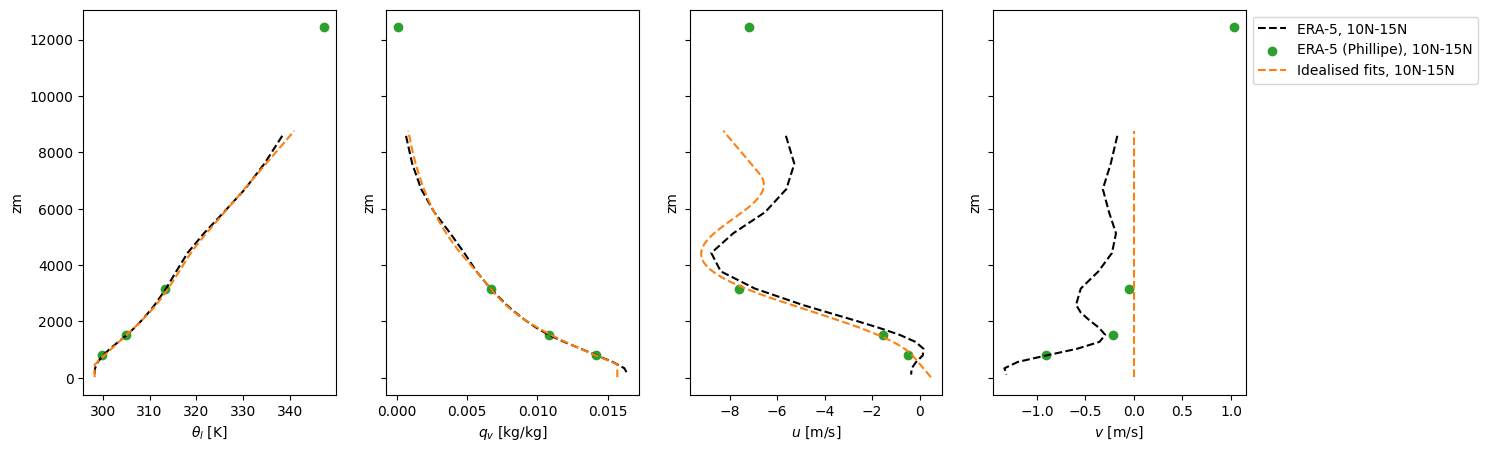

In [120]:
## Plot everything up to zpltmax (so this plot may truncate the simulation grid if zpltmax < zf[-1])
izmax = np.where(zf<zpltmax)[0][-1]
zfplt = zf[:izmax]
era5_env_mn_plt = era5_env_mn.sel(zm=slice(np.max(zfplt),np.min(zfplt)))

fig, axs = plt.subplots(ncols=4,figsize=(15,5),sharey=True)

era5_env_mn_plt['theta_l'].plot(y='zm', ax=axs[0], color=cs[0], linestyle=lss[1])
axs[0].scatter(ds_wai['theta_l'], ds_wai['zm'], c=cs[2])
axs[0].plot(thl[:izmax], zfplt, color=cs[1], linestyle=lss[1])
axs[0].set_xlabel(r'$\theta_l$ [K]')

era5_env_mn_plt['q'].plot(y='zm', ax=axs[1], color=cs[0], linestyle=lss[1])
axs[1].scatter(ds_wai['q'], ds_wai['zm'], c=cs[2])
axs[1].plot(qt[:izmax], zfplt, color=cs[1], linestyle=lss[1])
axs[1].set_xlabel(r'$q_v$ [kg/kg]')

era5_env_mn_plt['u'].plot(y='zm', ax=axs[2], color=cs[0], linestyle=lss[1])
axs[2].scatter(ds_wai['u'], ds_wai['zm'], c=cs[2])
axs[2].plot(u[:izmax], zfplt, color=cs[1], linestyle=lss[1])
axs[2].set_xlabel(r'$u$ [m/s]')

era5_env_mn_plt['v'].plot(y='zm', ax=axs[3], color=cs[0], linestyle=lss[1], label='ERA-5, '+lats[1])
axs[3].scatter(ds_wai['v'], ds_wai['zm'], c=cs[2], label='ERA-5 (Phillipe), '+lats[1])
axs[3].plot(v[:izmax], zfplt, color=cs[1], linestyle=lss[1], label='Idealised fits, '+lats[1])
axs[3].set_xlabel(r'$v$ [m/s]')

axs[3].legend(bbox_to_anchor=(1,1), loc='best')


In [92]:
parameters

,thls,dthllt,hqt,u0,ujet
0,299.511256,2.354826,3598.007748,1.796379,6.52969
